In [2]:
import torch

print("PyTorch version:", torch.__version__)
print("CUDA Available:", torch.cuda.is_available())
print("Device Count:", torch.cuda.device_count())
print("Current Device Index:", torch.cuda.current_device())
print("Device Name:", torch.cuda.get_device_name(torch.cuda.current_device()) if torch.cuda.is_available() else "CPU Only")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Active Device:", device)


PyTorch version: 2.7.1+cu118
CUDA Available: True
Device Count: 1
Current Device Index: 0
Device Name: NVIDIA GeForce GTX 1650
Active Device: cuda


In [3]:
import sys
print(sys.executable)



c:\Users\T2430479\miniconda3\envs\MAFL\python.exe


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from imblearn.over_sampling import SMOTE
from collections import Counter
import torch
import torch.nn as nn
import torch.utils.data as data_utils
import torch.nn.functional as F


from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
    roc_auc_score, 
    roc_curve
)



from sklearn.metrics import classification_report
from torch.utils.data import TensorDataset, DataLoader
from tqdm.notebook import tqdm



import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None)


In [5]:
# df = pd.read_parquet(r"E:\Thesis\P2\CNN+LSTM\CIC-ToN-IoT-V2.parquet")
# print(f"Dataset 1 Shape: {df.shape}")
# display(df.head(10))

# df1 = pd.read_csv(r"E:\Thesis\P2\CNN+LSTM\preprocessed_dataset.csv")
# print(f"Dataset 2 Shape: {df1.shape}")
# display(df1.head(10))

df2 = pd.read_csv(r"D:\T24\Yeasin's Model\Dataset\train_test_network.csv")
print(f"Dataset 3 Shape: {df2.shape}")
display(df2.head(10))


Dataset 3 Shape: (211043, 44)


,src_ip,src_port,dst_ip,dst_port,proto,service,duration,src_bytes,dst_bytes,conn_state,missed_bytes,src_pkts,src_ip_bytes,dst_pkts,dst_ip_bytes,dns_query,dns_qclass,dns_qtype,dns_rcode,dns_AA,dns_RD,dns_RA,dns_rejected,ssl_version,ssl_cipher,ssl_resumed,ssl_established,ssl_subject,ssl_issuer,http_trans_depth,http_method,http_uri,http_version,http_request_body_len,http_response_body_len,http_status_code,http_user_agent,http_orig_mime_types,http_resp_mime_types,weird_name,weird_addl,weird_notice,label,type
0,192.168.1.37,4444,192.168.1.193,49178,tcp,-,290.371539,101568,2592,OTH,0,108,108064,31,3832,-,0,0,0,-,-,-,-,-,-,-,-,-,-,-,-,-,-,0,0,0,-,-,-,-,-,-,1,backdoor
1,192.168.1.193,49180,192.168.1.37,8080,tcp,-,0.000102,0,0,REJ,0,1,52,1,40,-,0,0,0,-,-,-,-,-,-,-,-,-,-,-,-,-,-,0,0,0,-,-,-,-,-,-,1,backdoor
2,192.168.1.193,49180,192.168.1.37,8080,tcp,-,0.000148,0,0,REJ,0,1,52,1,40,-,0,0,0,-,-,-,-,-,-,-,-,-,-,-,-,-,-,0,0,0,-,-,-,-,-,-,1,backdoor
3,192.168.1.193,49180,192.168.1.37,8080,tcp,-,0.000113,0,0,REJ,0,1,48,1,40,-,0,0,0,-,-,-,-,-,-,-,-,-,-,-,-,-,-,0,0,0,-,-,-,-,-,-,1,backdoor
4,192.168.1.193,49180,192.168.1.37,8080,tcp,-,0.000130,0,0,REJ,0,1,52,1,40,-,0,0,0,-,-,-,-,-,-,-,-,-,-,-,-,-,-,0,0,0,-,-,-,-,-,-,1,backdoor
5,192.168.1.193,49180,192.168.1.37,8080,tcp,-,0.008403,0,0,REJ,0,1,52,1,40,-,0,0,0,-,-,-,-,-,-,-,-,-,-,-,-,-,-,0,0,0,-,-,-,-,-,-,1,backdoor
6,192.168.1.193,49180,192.168.1.37,8080,tcp,-,0.000137,0,0,REJ,0,1,48,1,40,-,0,0,0,-,-,-,-,-,-,-,-,-,-,-,-,-,-,0,0,0,-,-,-,-,-,-,1,backdoor
7,192.168.1.193,49180,192.168.1.37,8080,tcp,-,0.000143,0,0,REJ,0,1,52,1,40,-,0,0,0,-,-,-,-,-,-,-,-,-,-,-,-,-,-,0,0,0,-,-,-,-,-,-,1,backdoor
8,192.168.1.193,49180,192.168.1.37,8080,tcp,-,0.000200,0,0,REJ,0,1,52,1,40,-,0,0,0,-,-,-,-,-,-,-,-,-,-,-,-,-,-,0,0,0,-,-,-,-,-,-,1,backdoor
9,192.168.1.193,49180,192.168.1.37,8080,tcp,-,0.000009,0,0,REJ,0,1,52,1,40,-,0,0,0,-,-,-,-,-,-,-,-,-,-,-,-,-,-,0,0,0,-,-,-,-,-,-,1,backdoor


Missing values per column:
service                 132032
dns_query               176198
dns_AA                  176030
dns_RD                  176030
dns_RA                  176030
dns_rejected            176030
ssl_version             210642
ssl_cipher              210642
ssl_resumed             210642
ssl_established         210642
ssl_subject             211032
ssl_issuer              211032
http_trans_depth        210740
http_method             210756
http_uri                210756
http_version            210745
http_user_agent         210756
http_orig_mime_types    211027
http_resp_mime_types    210839
weird_name              210687
weird_addl              210886
weird_notice            210687
dtype: int64


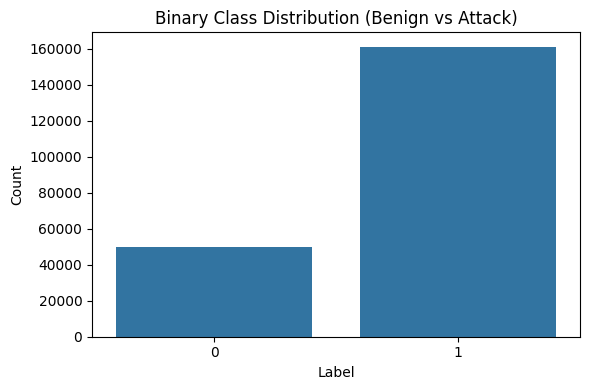

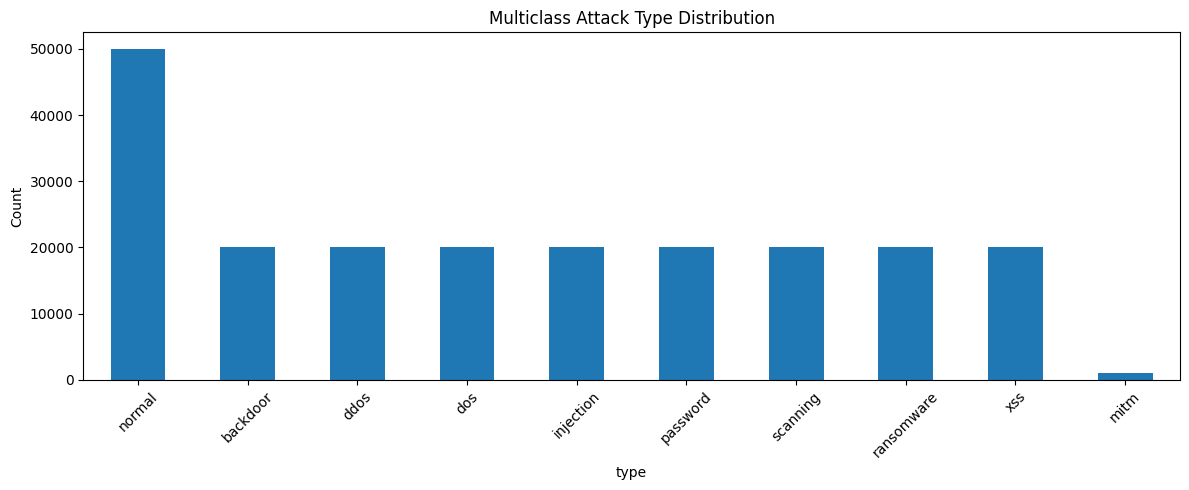

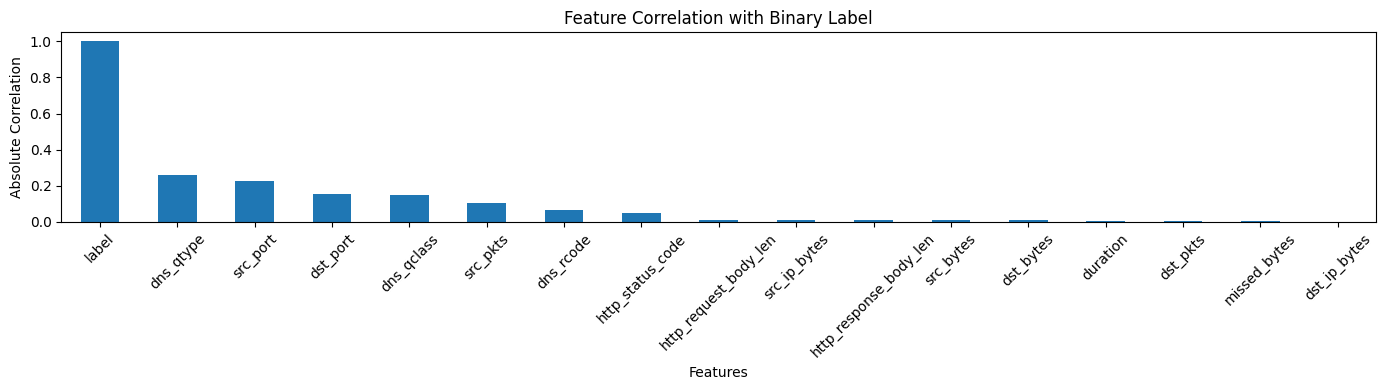

In [6]:
df2.replace('-', np.nan, inplace=True)

# 1. Missing values
missing = df2.isnull().sum()
print("Missing values per column:")
print(missing[missing > 0])

# 2. Binary class distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='label', data=df2)
plt.title("Binary Class Distribution (Benign vs Attack)")
plt.xlabel("Label")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# 3. Multiclass class distribution
plt.figure(figsize=(12, 5))
df2['type'].value_counts().plot(kind='bar')
plt.title("Multiclass Attack Type Distribution")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 4. Feature correlation with binary label
# Convert label to numeric if needed
if df2['label'].dtype == object:
    df2['Label_numeric'] = df2['label'].astype('category').cat.codes
else:
    df2['Label_numeric'] = df2['label']

# Get numeric columns
numeric_cols = df2.select_dtypes(include=['int8', 'int16', 'int32', 'int64', 'float32', 'float64']).columns.tolist()

# Remove label column from predictors
if 'Label_numeric' in numeric_cols:
    numeric_cols.remove('Label_numeric')

# Compute correlation with label
corr_with_label = df2[numeric_cols].corrwith(df2['Label_numeric']).abs().sort_values(ascending=False)

# Plot correlation
plt.figure(figsize=(14, 4))
corr_with_label.plot(kind='bar')
plt.title("Feature Correlation with Binary Label")
plt.xlabel("Features")
plt.ylabel("Absolute Correlation")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [7]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

# 1. Drop high-missing or non-useful columns
drop_cols = [
    'dns_query', 'ssl_subject', 'ssl_issuer',
    'http_uri', 'http_user_agent',
    'http_orig_mime_types', 'http_resp_mime_types',
    'weird_addl', 'ssl_resumed', 'ssl_established',
    'src_ip', 'dst_ip'  # <-- These are IP strings causing scaler crash
]
df2.drop(columns=drop_cols, inplace=True, errors='ignore')

# 2. Fill missing values
cat_fill_none = [
    'service', 'ssl_version', 'ssl_cipher',
    'http_method', 'http_version', 'weird_name', 'weird_notice'
]
df2[cat_fill_none] = df2[cat_fill_none].fillna('none')

bool_fill_zero = ['dns_AA', 'dns_RD', 'dns_RA', 'dns_rejected']
for col in bool_fill_zero:
    df2[col] = df2[col].astype(str).str.lower().replace({
        'true': 1, 't': 1, 'false': 0, 'f': 0, 'nan': 0, '-': 0
    })
    df2[col] = df2[col].astype(int)

df2['http_trans_depth'] = df2['http_trans_depth'].fillna(0)

# 3. Encode target column 'type' for multiclass
le_type = LabelEncoder()
df2['type_encoded'] = le_type.fit_transform(df2['type'])

# 4. Encode categorical features
categorical_cols = [
    'proto', 'service', 'conn_state', 'ssl_version', 'ssl_cipher',
    'http_method', 'http_version', 'weird_name', 'weird_notice'
]
for col in categorical_cols:
    df2[col] = LabelEncoder().fit_transform(df2[col].astype(str))

# 5. Extract only numeric features and scale
X = df2.drop(columns=['label', 'type', 'type_encoded'], errors='ignore')

# Drop remaining non-numeric columns if any slipped through
X = X.select_dtypes(include=['int64', 'float64', 'int32', 'float32'])

# Scale
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X = pd.DataFrame(X_scaled, columns=X.columns)

# 6. Targets
y_bin = df2['label']
y_multi = df2['type_encoded']

# 7. Info
print(f"Features shape: {X.shape}")
print(f"Binary target shape: {y_bin.shape}")
print(f"Multiclass target shape: {y_multi.shape}")

print("\nClass Distribution (Binary):")
print(y_bin.value_counts())

minority = y_bin.value_counts().min()
majority = y_bin.value_counts().max()
imbalance_ratio = majority / minority
print(f"\nImbalance Ratio: {imbalance_ratio:.2f}")


Features shape: (211043, 30)
Binary target shape: (211043,)
Multiclass target shape: (211043,)

Class Distribution (Binary):
label
1    161043
0     50000
Name: count, dtype: int64

Imbalance Ratio: 3.22


In [8]:
# 1. Binary Stratified Split
X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(
    X, y_bin, test_size=0.2, random_state=42, stratify=y_bin
)

print("Class distribution before SMOTE:", Counter(y_train_bin))

# # 2. Apply SMOTE 
# apply_smote = False

# if apply_smote:
#     smote = SMOTE(random_state=42)
#     X_train_bin_smote, y_train_bin_smote = smote.fit_resample(X_train_bin, y_train_bin)
#     print("Class distribution after SMOTE:", Counter(y_train_bin_smote))
# else:
#     X_train_bin_smote, y_train_bin_smote = X_train_bin, y_train_bin
#     print("SMOTE not applied.")

# # 3. Output shapes
# print(f"Train shape: {X_train_bin_smote.shape}, Test shape: {X_test_bin.shape}")


Class distribution before SMOTE: Counter({1: 128834, 0: 40000})


In [9]:
import torch
import torch.nn as nn
import torch.utils.data as data_utils
import os

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Convert data to tensors
X_train_tensor = torch.tensor(X_train_bin.values, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test_bin.values, dtype=torch.float32).to(device)

# DataLoader
batch_size = 512
train_loader = data_utils.DataLoader(
    data_utils.TensorDataset(X_train_tensor, X_train_tensor),
    batch_size=batch_size,
    shuffle=True
)

# Define Autoencoder
class Autoencoder(nn.Module):
    def __init__(self, input_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32)
        )
        self.decoder = nn.Sequential(
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, input_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Initialize model
input_dim = X_train_bin.shape[1]
autoencoder = Autoencoder(input_dim).to(device)

# Path to save/load model
model_path = "autoencoder_weights3.pth"

if os.path.exists(model_path):
    # Load pre-trained model
    autoencoder.load_state_dict(torch.load(model_path, map_location=device))
    autoencoder.eval()
    print("Loaded pre-trained Autoencoder from disk.")
else:
    # Train the model
    optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-3)
    criterion = nn.MSELoss()
    epochs = 50

    autoencoder.train()
    for epoch in range(epochs):
        total_loss = 0
        for xb, _ in train_loader:
            output = autoencoder(xb)
            loss = criterion(output, xb)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss / len(train_loader):.6f}")

    # Save trained model
    torch.save(autoencoder.state_dict(), model_path)
    print("Training complete. Model saved to disk.")


Epoch 1/50, Loss: 0.031449
Epoch 2/50, Loss: 0.002712
Epoch 3/50, Loss: 0.001111
Epoch 4/50, Loss: 0.000510
Epoch 5/50, Loss: 0.000368
Epoch 6/50, Loss: 0.000301
Epoch 7/50, Loss: 0.000263
Epoch 8/50, Loss: 0.000240
Epoch 9/50, Loss: 0.000226
Epoch 10/50, Loss: 0.000215
Epoch 11/50, Loss: 0.000207
Epoch 12/50, Loss: 0.000201
Epoch 13/50, Loss: 0.000197
Epoch 14/50, Loss: 0.000193
Epoch 15/50, Loss: 0.000190
Epoch 16/50, Loss: 0.000187
Epoch 17/50, Loss: 0.000181
Epoch 18/50, Loss: 0.000178
Epoch 19/50, Loss: 0.000176
Epoch 20/50, Loss: 0.000173
Epoch 21/50, Loss: 0.000170
Epoch 22/50, Loss: 0.000168
Epoch 23/50, Loss: 0.000166
Epoch 24/50, Loss: 0.000165
Epoch 25/50, Loss: 0.000163
Epoch 26/50, Loss: 0.000161
Epoch 27/50, Loss: 0.000159
Epoch 28/50, Loss: 0.000147
Epoch 29/50, Loss: 0.000134
Epoch 30/50, Loss: 0.000134
Epoch 31/50, Loss: 0.000132
Epoch 32/50, Loss: 0.000131
Epoch 33/50, Loss: 0.000131
Epoch 34/50, Loss: 0.000130
Epoch 35/50, Loss: 0.000130
Epoch 36/50, Loss: 0.000129
E

In [10]:
autoencoder.eval()

with torch.no_grad():
    reconstructed_test = autoencoder(X_test_tensor).cpu().numpy()

reconstruction_error = np.mean((X_test_bin.values - reconstructed_test) ** 2, axis=1)

print(f"Mean Reconstruction Error: {reconstruction_error.mean():.6f}")
print(f"Std of Reconstruction Error: {reconstruction_error.std():.6f}")


Mean Reconstruction Error: 0.000074
Std of Reconstruction Error: 0.001220


In [11]:
with torch.no_grad():
    X_train_encoded = autoencoder.encoder(X_train_tensor).cpu().numpy()
    X_test_encoded = autoencoder.encoder(X_test_tensor).cpu().numpy()

print("Encoded feature shapes:")
print("Train:", X_train_encoded.shape)
print("Test :", X_test_encoded.shape)


Encoded feature shapes:
Train: (168834, 32)
Test : (42209, 32)


In [12]:
print("Before SMOTE:", Counter(y_train_bin))

smote = SMOTE(random_state=42)
X_train_encoded_smote, y_train_smote = smote.fit_resample(X_train_encoded, y_train_bin)

print("After SMOTE :", Counter(y_train_smote))
print(f"Final Train shape: {X_train_encoded_smote.shape}, Final Test shape: {X_test_encoded.shape}")

Before SMOTE: Counter({1: 128834, 0: 40000})
After SMOTE : Counter({1: 128834, 0: 128834})
Final Train shape: (257668, 32), Final Test shape: (42209, 32)


In [13]:
class CNN_BiLSTM_Binary(nn.Module):
    def __init__(self, input_size=1, seq_len=32, hidden_dim=64, lstm_layers=1):
        super(CNN_BiLSTM_Binary, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=input_size, out_channels=16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(16)
        self.relu = nn.ReLU()

        self.lstm = nn.LSTM(
            input_size=16,
            hidden_size=hidden_dim,
            num_layers=lstm_layers,
            batch_first=True,
            bidirectional=True
        )

        self.fc = nn.Sequential(
            nn.Linear(2 * hidden_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        # input: [B, 1, seq_len] → no need to unsqueeze
        x = self.relu(self.bn1(self.conv1(x)))  # [B, 16, seq_len]
        x = x.transpose(1, 2)                   # [B, seq_len, 16]
        out, _ = self.lstm(x)                   # [B, seq_len, 2*hidden_dim]
        out = out[:, -1, :]                     # [B, 2*hidden_dim]
        out = self.fc(out)                      # [B, 1]
        return out.squeeze(1)                   # [B]



Fold 1/5


Fold 1 Training:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50 | Train Loss: 0.0776 | Val Loss: 0.0028 | F1: 0.9995
Epoch 2/50 | Train Loss: 0.0029 | Val Loss: 0.0009 | F1: 1.0000
Epoch 3/50 | Train Loss: 0.0009 | Val Loss: 0.0002 | F1: 1.0000
Epoch 4/50 | Train Loss: 0.0004 | Val Loss: 0.0001 | F1: 1.0000
Epoch 5/50 | Train Loss: 0.0003 | Val Loss: 0.0002 | F1: 0.9999
Epoch 6/50 | Train Loss: 0.0002 | Val Loss: 0.0000 | F1: 1.0000
Epoch 7/50 | Train Loss: 0.0001 | Val Loss: 0.0000 | F1: 1.0000
Epoch 8/50 | Train Loss: 0.0012 | Val Loss: 0.0002 | F1: 1.0000
Epoch 9/50 | Train Loss: 0.0004 | Val Loss: 0.0002 | F1: 1.0000
Epoch 10/50 | Train Loss: 0.0003 | Val Loss: 0.0000 | F1: 1.0000
Early stopping triggered.


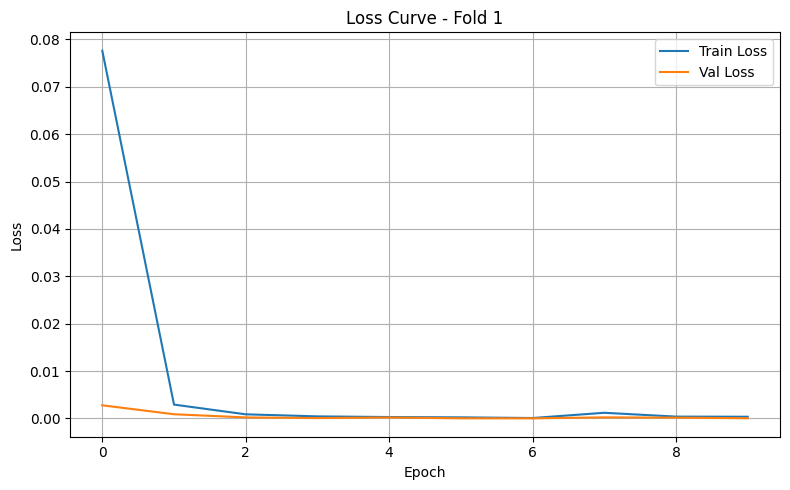


Fold 2/5


Fold 2 Training:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50 | Train Loss: 0.0668 | Val Loss: 0.0024 | F1: 0.9994
Epoch 2/50 | Train Loss: 0.0041 | Val Loss: 0.0007 | F1: 0.9999
Epoch 3/50 | Train Loss: 0.0020 | Val Loss: 0.0004 | F1: 0.9999
Early stopping triggered.


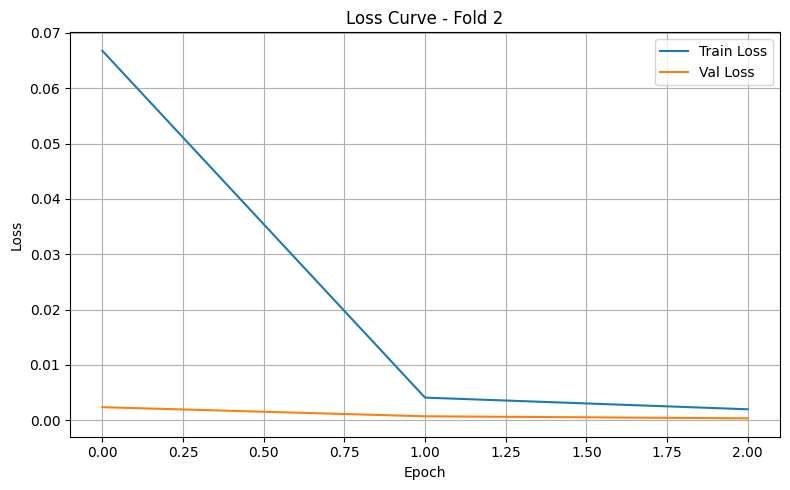


Fold 3/5


Fold 3 Training:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50 | Train Loss: 0.0646 | Val Loss: 0.0044 | F1: 0.9988
Epoch 2/50 | Train Loss: 0.0038 | Val Loss: 0.0021 | F1: 0.9995
Epoch 3/50 | Train Loss: 0.0014 | Val Loss: 0.0006 | F1: 1.0000
Early stopping triggered.


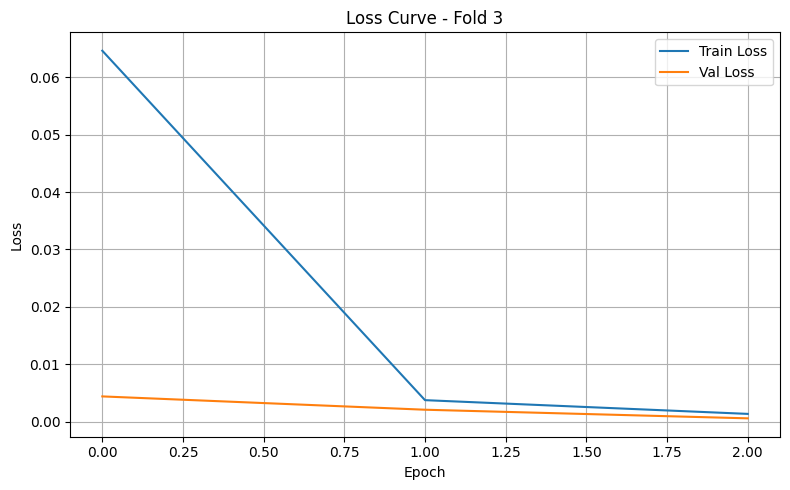


Fold 4/5


Fold 4 Training:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50 | Train Loss: 0.0708 | Val Loss: 0.0042 | F1: 0.9990
Epoch 2/50 | Train Loss: 0.0030 | Val Loss: 0.0013 | F1: 0.9994
Epoch 3/50 | Train Loss: 0.0006 | Val Loss: 0.0004 | F1: 1.0000
Early stopping triggered.


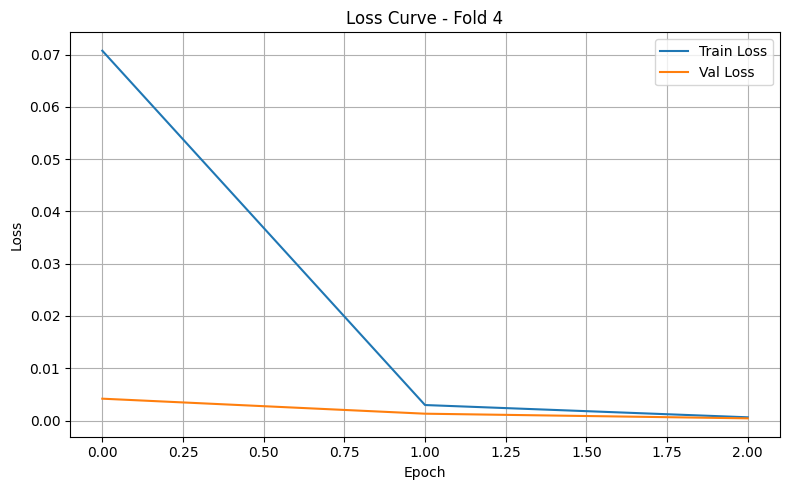


Fold 5/5


Fold 5 Training:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50 | Train Loss: 0.0726 | Val Loss: 0.0039 | F1: 0.9991
Epoch 2/50 | Train Loss: 0.0042 | Val Loss: 0.0039 | F1: 0.9991
Epoch 3/50 | Train Loss: 0.0030 | Val Loss: 0.0023 | F1: 0.9996
Early stopping triggered.


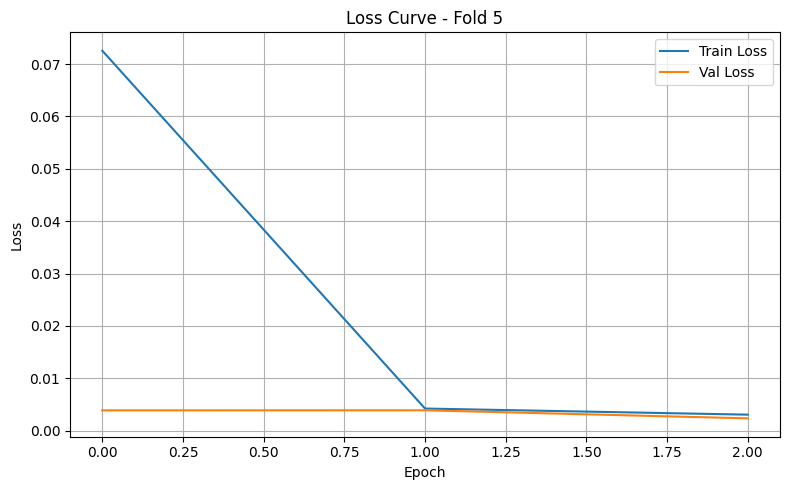


Average F1 Score over 5 folds: 0.9999


In [14]:
import matplotlib.pyplot as plt

X = pd.DataFrame(X_train_encoded_smote)  # shape: (n_samples, 32)
y = pd.Series(y_train_smote).reset_index(drop=True)

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model config
seq_len = X.shape[1]
input_size = 1
batch_size = 512
epochs = 50
patience = 3
weight_decay = 1e-5

# K-Fold Setup
k_folds = 5
skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

# Class imbalance handling 
pos_weight = torch.tensor([(y == 0).sum() / (y == 1).sum()], dtype=torch.float32).to(device)

# Tracking best model
f1_scores = []
best_val_loss = float('inf')
best_model_state = None

# Start K-Fold Training
for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    print(f"\nFold {fold+1}/{k_folds}")

    # Split data
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    # Convert to tensors (no reshaping here)
    X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32).to(device)
    y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).to(device)
    X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32).to(device)
    y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).to(device)

    # DataLoaders
    train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=batch_size)

    # Model, loss, optimizer
    model = CNN_BiLSTM_Binary(input_size=input_size, seq_len=seq_len).to(device)
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=weight_decay)

    early_stop_counter = 0
    train_losses = []
    val_losses = []

    # Training loop
    for epoch in tqdm(range(epochs), desc=f"Fold {fold+1} Training"):
        model.train()
        total_loss = 0
        for xb, yb in train_loader:
            xb = xb.unsqueeze(1).to(device)  # [batch_size, 1, 32]
            yb = yb.to(device)

            optimizer.zero_grad()
            logits = model(xb)
            loss = criterion(logits, yb)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_train_loss = total_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation
        model.eval()
        val_loss = 0
        all_preds, all_labels = [], []
        with torch.no_grad():
            for xb, yb in val_loader:
                xb = xb.unsqueeze(1).to(device)
                yb = yb.to(device)

                logits = model(xb)
                loss = criterion(logits, yb)
                val_loss += loss.item()

                preds = (torch.sigmoid(logits) > 0.5).int().cpu().numpy()
                all_preds.extend(preds)
                all_labels.extend(yb.cpu().numpy())

        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        f1 = f1_score(all_labels, all_preds, average='macro')
        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | F1: {f1:.4f}")

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_state = model.state_dict()
            torch.save(best_model_state, f"best_model_binary_foldD3.pth")
            early_stop_counter = 0
        else:
            early_stop_counter += 1
            if early_stop_counter >= patience:
                print("Early stopping triggered.")
                break

    f1_scores.append(f1)

    # Plot loss curve for the current fold
    plt.figure(figsize=(8, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"Loss Curve - Fold {fold+1}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Final Results
print(f"\nAverage F1 Score over {k_folds} folds: {np.mean(f1_scores):.4f}")



Final Test Set Evaluation
              precision    recall  f1-score   support

           0     0.9999    1.0000    1.0000     10000
           1     1.0000    1.0000    1.0000     32209

    accuracy                         1.0000     42209
   macro avg     1.0000    1.0000    1.0000     42209
weighted avg     1.0000    1.0000    1.0000     42209



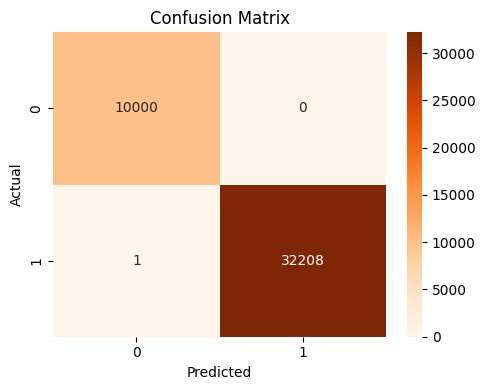

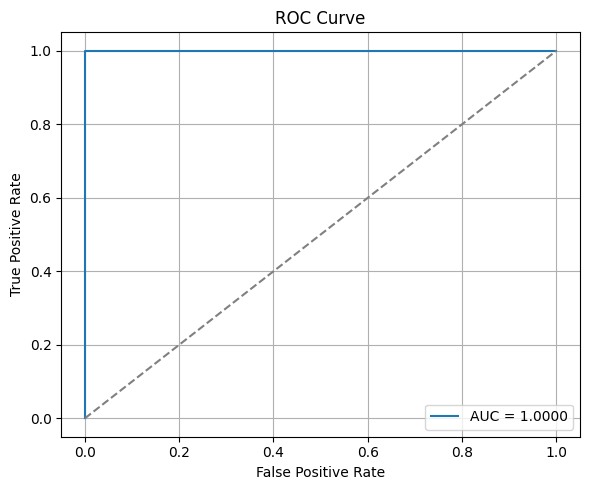

In [15]:
X_test_df = pd.DataFrame(X_test_encoded)
seq_len_test = X_test_df.shape[1]


X_test_tensor = torch.tensor(X_test_df.values, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test_bin.values, dtype=torch.float32).to(device)


model = CNN_BiLSTM_Binary(input_size=1, seq_len=seq_len_test).to(device)
model.load_state_dict(torch.load("best_model_binary_foldD3.pth", map_location=device))
model.eval()


probs, test_preds = [], []
with torch.no_grad():
    for i in range(0, len(X_test_tensor), batch_size):
        xb = X_test_tensor[i:i + batch_size].unsqueeze(1)  # Shape: [B, 1, 32]
        logits = model(xb)
        prob = torch.sigmoid(logits).squeeze()  # Shape: [B]
        pred = (prob > 0.5).int()

        probs.extend(prob.cpu().numpy())
        test_preds.extend(pred.cpu().numpy())

y_test_np = y_test_bin.values
probs = np.array(probs)
test_preds = np.array(test_preds)

# Evaluation Report
print("\nFinal Test Set Evaluation")
print(classification_report(y_test_np, test_preds, digits=4))

# Confusion Matrix
cm = confusion_matrix(y_test_np, test_preds)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test_np, probs)
auc = roc_auc_score(y_test_np, probs)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()